# Variational Autoregressive Network on Ising Model

Here, we attempt to sample and output log-probabilities approximately using a variational autoregressive network that trains to minimize free energy

If opening directly on Colab (or downloaded this notebook alone locally), run the following cell to download the dependencies of this noteook:

In [ ]:
!curl -o ising.py https://raw.githubusercontent.com/dinesh110598/ising-autoregressive/main/ising.py
!curl -o train.py https://raw.githubusercontent.com/dinesh110598/ising-autoregressive/main/train.py
!curl -o library.py https://raw.githubusercontent.com/dinesh110598/ising-autoregressive/main/library.py

Here, we import tensorflow (2.x) and other dependent modules:

In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt
import train #User defined module to run training loop
import ising #User defined module to prescribe ising model
import library #User defined module to define the models

## Naive PixelCNN architecture

We're going to use the PixelCNN architecture which uses a masked convolutional neural network to return some probabilities, given an input lattice of Ising spins. Let's initialize the network with depth 2, which has one Masked Convolution layer with a LeakyRelu activation and a 1-kernel regular convolutional layer: 

In [23]:
model = library.PixelCNN(L=24, net_depth=3, net_width=16, kernel_size=3)#See library.py for more details
ising.J = -1. #Fixes the coupling constant in Ising model
trainer = train.Trainer(model, batch_size=50)

Let's check out the model design here:

In [3]:
trainer.model.net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masked_conv2d (MaskedConv2D) (None, 24, 24, 16)        416       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        272       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 1)         17        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


This is an unsupervised learning model since the network generates its own training data. In particular, we're attempting reinforcement learning to optimize the (expectation value of) free energy of the generated lattices. Let's train the model we defined here.

In [ ]:
beta = 0.5
history = trainer.train_loop(iter=100, beta=beta, anneal=True)
#Set anneal=False if you are running this cell second 
#time to train this model further

The output object "history" is a python dictionary which records the values of various metrics like free energy, energy and time taken per training step. This helps us visualize how the training performance so that we can tweak various parameters to improve it. Here, we plot mean energy against the training step:

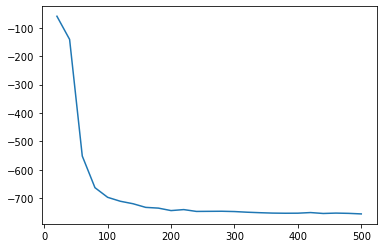

In [5]:
x = history['step']
y = history['Energy mean']
plt.plot(x, y)

Let's calculate and plot the exact theoretical free energy of the infinite square ferromagnetic Ising model($K=\beta$). We'll use the SciPy method "quad" to find this integral:
$$ -\beta F = \frac{log(2)}{2} + \frac{1}{2 \pi} \int_0^\pi log\left[ cosh^2(2K) + \frac{1}{k}\sqrt{1 + k^2 - 2k.cos(2\theta)} \right] d\theta$$
where $$ k = \frac{1}{sinh^2(2K)}$$

In [5]:
from scipy import integrate
import math

In [6]:
#The function to evaluate integral of
def func(theta, beta):
    t1 = math.cosh(2*beta)**2
    k = 1./(math.sinh(2*beta)**2)
    t2 = (1./k)*math.sqrt(1 + k**2 - 2*k*math.cos(2*theta))
    return math.log(t1 + t2)

We use this function to evaluate the integral over a vector of values for beta:

In [7]:
def integrator(beta):
    result = np.empty(beta.shape, float)
    for i in range(beta.shape[0]):
        val = beta[i]
        integrand = lambda theta: func(theta, val)
        result[i] = integrate.quad(integrand, 0 , math.pi)[0]
    return result

beta = np.arange(0.25, 0.65, 0.0125)
integral = integrator(beta)
F = -np.reciprocal(beta)*(math.log(2)/2 + integral*(1./(2*math.pi)))

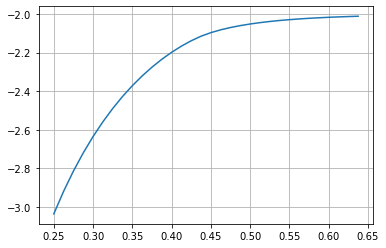

In [7]:
plt.plot(beta, F)
plt.grid()
plt.show()

Here, we have the plot free energy against temperature evaluated from the exact theoretical solution

Instead of training for many values of beta from the scratch, we'll directly download a folder containing the trained neural network weights:

In [ ]:
#Uncomment below line and run in case of using Colab
#!svn export 'https://github.com/dinesh110598/ising-autoregressive/trunk/PCNN_Weights'

We'll sample a batch of 100 lattices each for each value in the list "betas".

In [24]:
model = trainer.model
betas = [0.3,0.35,0.4,0.425,0.45,
        0.475,0.5,0.55,0.6]
sample = []
log_prob = []
energy = []
free_energy = []

for beta in betas:
    model.load_weights('PCNN_Weights/b_'+str(beta))
    sample.append(model.sample(100))
    log_prob.append(model.log_prob(sample[-1]))
    energy.append(ising.energy(sample[-1], pbc=True))
    free_energy.append(np.mean(((log_prob[-1]/beta)+energy[-1])/(model.L**2)))

In [25]:
beta = np.arange(0.3, 0.60001, 0.0125)
integral = integrator(beta)
F = -np.reciprocal(beta)*(math.log(2)/2 + integral*(1./(2*math.pi)))

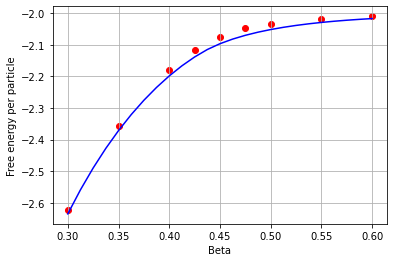

In [26]:
plt.plot(beta, F, color='blue')
plt.scatter(betas, free_energy, color='red')
plt.xlabel('Beta')
plt.ylabel('Free energy per particle')
plt.grid()
plt.show()

Let's estimate the errors in our free energy estimates:

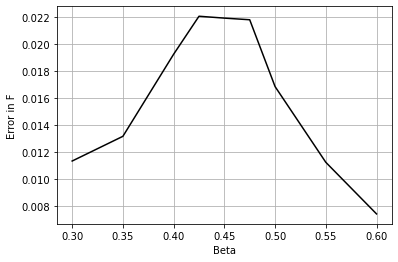

In [27]:
betas = np.asarray(betas)
integral = integrator(betas)
F = -np.reciprocal(betas)*(math.log(2)/2 + integral*(1./(2*math.pi)))
free_energy_arr = np.asarray(free_energy)
error = (free_energy_arr-F)

plt.plot(betas, error, color='black')
plt.xlabel('Beta')
plt.ylabel('Error in F')
plt.grid()
plt.show()

In [28]:
betas1 = betas
error1 = error

## Improved PixelCNN model

In [6]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt
import train #User defined module to run training loop
import ising #User defined module to prescribe ising model
import library #User defined module to define the models

As suggested in [this paper](https://arxiv.org/pdf/1606.05328), there's the naive PixelCNN architecture has limited learning capability (compared to PixelRNN) and has an information blindspot when it's multiple layers deep. Hence, we perform seperate horizontal and vertical convolutions in the new model we call AdvPixelCNN:

In [29]:
model = library.AdvPixelCNN(L=36, kernel_size=2,
                net_width=[16,8], gated=False)#See library.py for more details
ising.J = -1. #Fixes the coupling constant in Ising model
trainer = train.Trainer(model, batch_size=50)

In [30]:
trainer.model.net.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nat_conv_block_1 (NatConvBlo (None, 36, 36, 16)        385       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 36, 36, 1)         17        
Total params: 402
Trainable params: 402
Non-trainable params: 0
_________________________________________________________________


In [16]:
beta=0.3
history = trainer.train_loop(iter=2000, 
            beta=beta, anneal=True)
#Set anneal=False if you are running this cell second 
#time to train this model further

100%|██████████| 20/20 [04:16<00:00, 12.84s/it]


In [19]:
history['Energy mean'][-10:]

[<tf.Tensor: shape=(), dtype=float32, numpy=-1097.96>]

In [7]:
trainer.model.save_weights('b_0.3')

Compare free energy of trained model with the exact solution:

In [3]:
from scipy import integrate
import math

In [4]:
#The function to evaluate integral of
def func(theta, beta):
    t1 = math.cosh(2*beta)**2
    k = 1./(math.sinh(2*beta)**2)
    t2 = (1./k)*math.sqrt(1 + k**2 - 2*k*math.cos(2*theta))
    return math.log(t1 + t2)

def integrator(beta):
    result = np.empty(beta.shape, float)
    for i in range(beta.shape[0]):
        val = beta[i]
        integrand = lambda theta: func(theta, val)
        result[i] = integrate.quad(integrand, 0 , math.pi)[0]
    return result

In [ ]:
#Uncomment below lines and run in case of using Colab
#!apt install subversion
#!svn export 'https://github.com/dinesh110598/ising-autoregressive/trunk/AdvPCNN_Weights'

In [31]:
model = trainer.model
betas = [0.3,0.35,0.4,0.425,0.45,
        0.475,0.5,0.55,0.6]
sample = []
log_prob = []
energy = []
free_energy = []

for beta in betas:
    model.load_weights('AdvPCNN_Weights2/b_'+str(beta))
    sample.append(model.sample(100))
    log_prob.append(model.log_prob(sample[-1]))
    energy.append(ising.energy(sample[-1], pbc=True))
    free_energy.append(np.mean(((log_prob[-1]/beta)+energy[-1])/(model.L**2)))

In [32]:
beta = np.arange(0.3, 0.60001, 0.0125)
integral = integrator(beta)
F = -np.reciprocal(beta)*(math.log(2)/2 + integral*(1./(2*math.pi)))

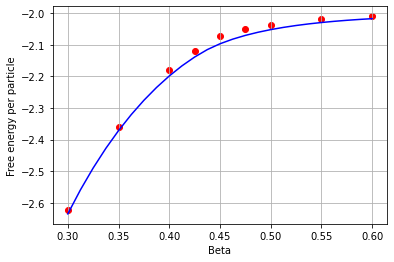

In [33]:
plt.plot(beta, F, color='blue')
plt.scatter(betas, free_energy, color='red')
plt.xlabel('Beta')
plt.ylabel('Free energy per particle')
plt.grid()
plt.show()

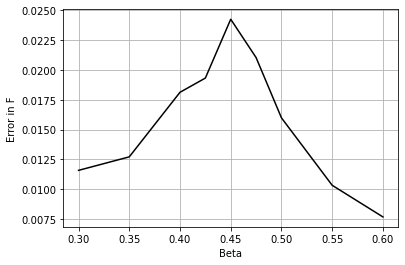

In [34]:
betas = np.asarray(betas)
integral = integrator(betas)
F = -np.reciprocal(betas)*(math.log(2)/2 + integral*(1./(2*math.pi)))
free_energy_arr = np.asarray(free_energy)
error2 = (free_energy_arr-F)

plt.plot(betas, error2, color='black')
plt.xlabel('Beta')
plt.ylabel('Error in F')
plt.grid()
plt.show()

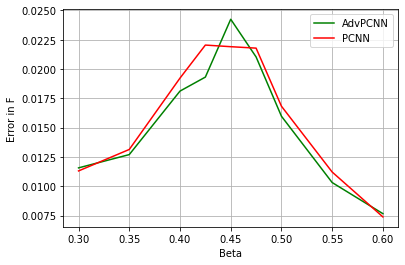

In [35]:
plt.plot(betas, error2, color='green')
plt.plot(betas1, error1, color='red')
plt.legend(['AdvPCNN', 'PCNN'])
plt.xlabel('Beta')
plt.ylabel('Error in F')
plt.grid()
plt.show()

## Additional training on larger lattices

Let's define an AdvPCNN model with depth 2 but lattice length L=36 instead of L=24 we already used. Then we'll load the weights correspoding to the L=24 it already trained with and further train with L=36

In [8]:
model = library.AdvPixelCNN(L=36, kernel_size=5, 
                            net_width=[8,4], gated=False)
beta = 0.3
model.load_weights("AdvPCNN_Weights/b_"+str(beta))
trainer = train.Trainer(model, 50, learning_rate=0.005)

In [ ]:
history = trainer.train_loop(iter=2000, 
            beta=beta, anneal=True)
#Set anneal=False if you are running this cell second 
#time to train this model further